In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import sys
print(sys.executable)

C:\Users\jenas\OneDrive\Desktop\House_prediction\.venv\Scripts\python.exe


In [3]:
DATA_DIR = Path("../data/raw")

train_df = pd.read_csv(DATA_DIR / r"train.csv")
test_df  = pd.read_csv(DATA_DIR / r"test.csv")

train_df.shape, test_df.shape

((1460, 81), (1459, 80))

# Problem Definition

- Task: Supervised Regression
- Target Variable: SalePrice
- Input: 80 features in X (after dropping target)
- Evaluation Metric: RMSE (later)

In [4]:
target = "SalePrice"
X = train_df.drop(columns=[target])
y = train_df[target]

X.shape, y.shape

((1460, 80), (1460,))

## Feature Type Split
Identify numerical and categorical features to guide preprocessing and encoding strategies.

In [5]:
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

len(numerical_features), len(categorical_features)

(37, 43)

## Missing Value Analysis
Analyze missing values to determine appropriate imputation strategies and identify features where missingness may be informative.

In [6]:
missing = (
    X.isnull().sum().sort_values(ascending=False)
)
missing[missing > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageQual        81
GarageFinish      81
GarageCond        81
GarageYrBlt       81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtQual          37
BsmtCond          37
MasVnrArea         8
Electrical         1
dtype: int64

## Target Variable Distribution
Examine the distribution of SalePrice to assess skewness and the need for transformation.

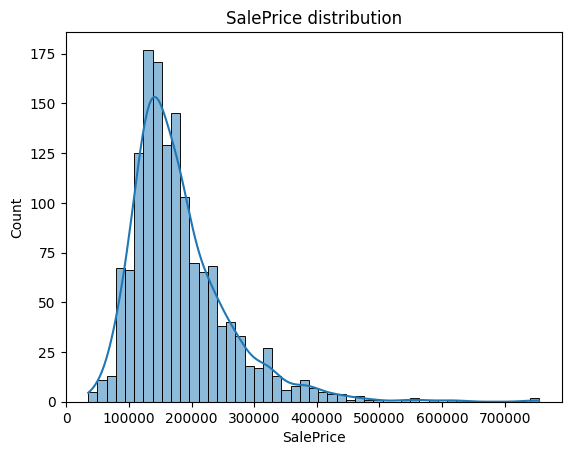

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.histplot(y, kde=True)
plt.title("SalePrice distribution")
plt.show()

In [8]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [9]:
num_missing = X[numerical_features].isnull().sum()
num_missing[num_missing > 0].sort_values(ascending=False).head(10)

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64

In [10]:
cat_missing = X[categorical_features].isnull().sum()
cat_missing[cat_missing > 0].sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
GarageFinish      81
GarageQual        81
GarageType        81
GarageCond        81
dtype: int64

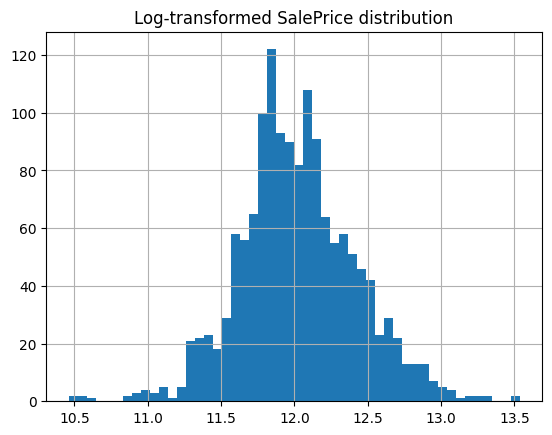

(np.float64(1.8828757597682129), np.float64(0.12134661989685333))

In [11]:
import numpy as np
np.log1p(y).hist(bins=50)
plt.title("Log-transformed SalePrice distribution")
plt.show()

y.skew(), np.log1p(y).skew()

## Correlation Analysis
Evaluate relationships between numerical features and the target variable to identify strong predictors.

In [12]:
corr = train_df[numerical_features.tolist() + ["SalePrice"]].corr()
corr["SalePrice"].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

## Location-based Price Analysis
Analyze how neighborhood impacts house prices, highlighting the importance of categorical feature encoding.

In [13]:
train_df.groupby("Neighborhood")["SalePrice"].median().sort_values(ascending=False).head(10)

Neighborhood
NridgHt    315000.0
NoRidge    301500.0
StoneBr    278000.0
Timber     228475.0
Somerst    225500.0
Veenker    218000.0
Crawfor    200624.0
ClearCr    200250.0
CollgCr    197200.0
Blmngtn    191000.0
Name: SalePrice, dtype: float64

# Missing Value Strategy (Draft)

- Numerical features will use median imputation due to skewed distributions.
- Categorical features will use "None" where missingness indicates absence (e.g., Garage, Pool), otherwise mode.
- Features with >40% missing values will be reviewed individually during preprocessing.